In [1]:
# Imports
%matplotlib inline

import warnings
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from helpers import OneStepTimeSeriesSplit, run_cv, stack_results, plot_result

In [2]:
# Defining path for results
results_path = Path('./results')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [3]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice

### PCA Engineered Features

In [4]:
# Getting PCA Engineered Features
data = pd.read_csv('./data/pcafeatureset.csv')
data.set_index(['ticker','date'], inplace=True)
data.dropna(inplace=True)

In [5]:
# Getting cross-validation sets
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

### XGBoost

In [ ]:
# Getting features and targets from data
X = data.iloc[:,:30]
y = pd.DataFrame((data.iloc[:,-6]>0).astype(int))

In [11]:
# Defining metrics
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [12]:
# Initialising model
xgb_clf = XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=100,silent=True,objective='binary:logistic',booster='gbtree',
                        n_jobs=-1,gamma=0,min_child_weight=1,max_delta_step=0,subsample=1,colsample_bytree=1,
                        colsample_bylevel=1,reg_alpha=0,reg_lambda=1,scale_pos_weight=1,base_score=0.5)

In [13]:
# Cross-validating model
fname = results_path / 'xgboost.joblib'
if not Path(fname).exists():
    xgb_cv_result = run_cv(xgb_clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

In [14]:
# Evaluating cross-validation results
xbg_result = stack_results(xgb_cv_result, metrics)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531216,0.594204
Accuracy,0.517643,0.549799
F1,0.475299,0.523594
Log Loss,-0.706097,-0.679735
Precision,0.679752,0.574831
Recall,0.469819,0.565026


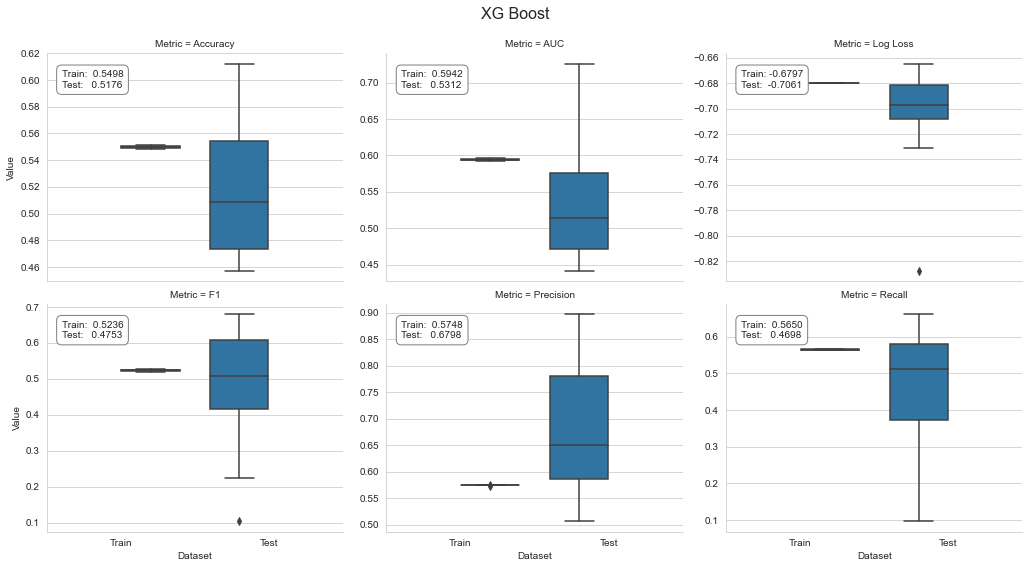

In [15]:
# Plotting cross-validation results
plot_result(xbg_result, metrics, model='XG Boost')

In [16]:
# Preparing data for training
Y = pd.DataFrame((data.iloc[:,-6:]>0).astype(int))
X_train = X.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]
y_train = Y.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]

In [17]:
y_train

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02           0           1            0            0   
       2015-01-05           0           1            0            0   
       2015-01-06           1           1            0            1   
       2015-01-07           1           0            0            0   
       2015-01-08           0           0            0            0   
...                       ...         ...          ...          ...   
ZTS    2019-12-24           1           1            1            1   
       2019-12-26           1           1            1            1   
       2019-12-27           0           0            1            1   
       2019-12-30           1           1            1            1   
       2019-12-31           1           1            1            1   

                   target42day  target63day  
ticker date                                  
A      2015-01-02            1            1  
       2015-01-05            1            1  
       2015-01-06            1            1  
       2015-01-07            1            1  
       2015-01-08            0            1  
...                        ...          ...  
ZTS    2019-12-24            1            0  
       2019-12-26            1            0  
       2019-12-27            1            0  
       2019-12-30            1            0  
       2019-12-31            1            0  

[614879 rows x 6 columns]

In [45]:
# Training model lag-wise
targets = [1,5,10,21,42,63]
y_pred = pd.DataFrame(index = Y.index)
for x in range(len(targets)):
    xgb_clf.fit(X=X_train, y=y_train.iloc[:,x])
    y_p = xgb_clf.predict(X)
    y_p = pd.DataFrame(y_p, index=Y.index, columns=[Y.columns[x]])
    y_pred = y_pred.join(y_p)

[15:33:17] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:33:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:30] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:35:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation me

In [46]:
# Predictions
y_pred

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02           1           1            1            1   
       2015-01-05           1           1            1            1   
       2015-01-06           1           1            1            1   
       2015-01-07           1           1            1            1   
       2015-01-08           0           1            1            1   
...                       ...         ...          ...          ...   
ZTS    2020-09-25           1           1            1            0   
       2020-09-28           1           1            1            0   
       2020-09-29           1           1            0            0   
       2020-09-30           1           0            0            0   
       2020-10-01           1           1            1            1   

                   target42day  target63day  
ticker date                                  
A      2015-01-02            1            1  
       2015-01-05            1            1  
       2015-01-06            1            1  
       2015-01-07            1            1  
       2015-01-08            1            1  
...                        ...          ...  
ZTS    2020-09-25            0            0  
       2020-09-28            0            0  
       2020-09-29            0            0  
       2020-09-30            0            0  
       2020-10-01            1            1  

[709062 rows x 6 columns]

In [47]:
#Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [50]:
# Joining OHLCV data with predictions
xgb_preds = ohlcv.join(y_pred).dropna()
xgb_preds.reset_index(inplace=True)
xgb_preds.date = pd.to_datetime(xgb_preds.date)
xgb_preds.set_index(['ticker','date'], inplace=True)

In [52]:
xgb_preds.to_csv('./predictions/xgb_preds.csv')

### LightGBM

In [39]:
# Initialising model
lgbm = LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.1,n_estimators=100,subsample_for_bin=200000,
                    class_weight=None,min_split_gain=0.0,min_child_weight=0.001,min_child_samples=20,subsample=1.0,
                    subsample_freq=0,colsample_bytree=1.0,reg_alpha=0.0,reg_lambda=0.0,n_jobs=-1,silent=True)

In [40]:
# Getting features and targets from data
X = data.iloc[:,:30]
y = (data.iloc[:,-6]>0).astype(int)

In [41]:
# Defining metrics
metrics = {'neg_mean_squared_error': 'NMSE' ,
           'neg_mean_absolute_error': 'NMAE',
           'neg_mean_squared_log_error': 'NMSLE',
           'r2': 'R2'
}

In [44]:
# Cross-validating model
fname = results_path / 'lightgbm.joblib'
if not Path(fname).exists():
    lgbm_cv_result = run_cv(lgbm, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1)
    joblib.dump(lgbm_cv_result, fname)
else:
    lgbm_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.5min remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


In [45]:
# Evaluating cross-validation results
lgbm_result = stack_results(lgbm_cv_result, metrics)
lgbm_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
NMAE,-0.507462,-0.476807
NMSE,-0.261860,-0.233028
NMSLE,-0.128525,-0.115436
R2,-1.140010,0.065347


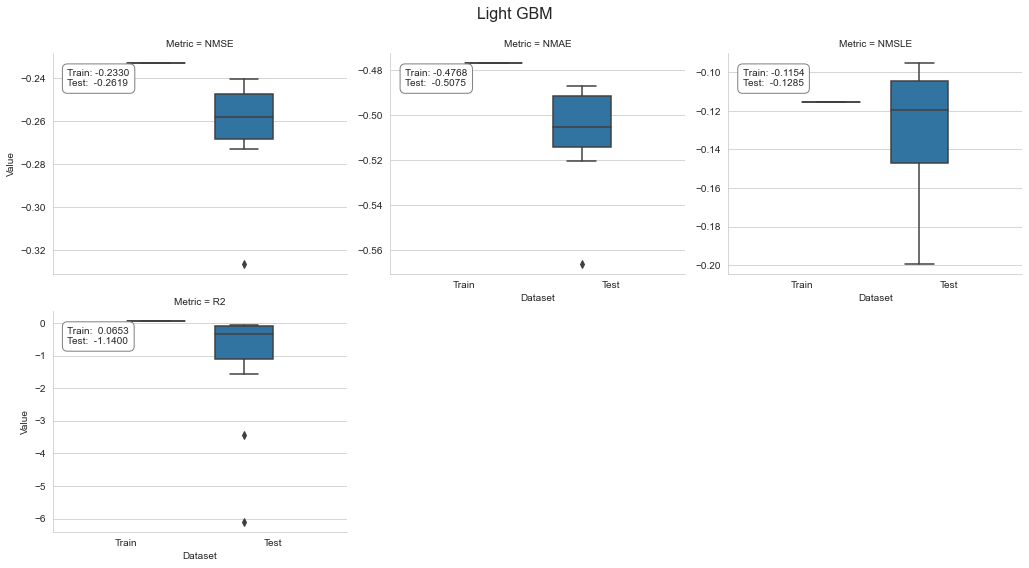

In [90]:
# Plotting cross-validation results
plot_result(lgbm_result, metrics, model='Light GBM')

In [100]:
# Preparing data for training
X = data.iloc[:,:30]
Y = data.iloc[:,-6:]
X_train = X.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]
y_train = Y.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]

In [101]:
# Training model lag wise
targets = [1,5,10,21,42,63]
y_pred = pd.DataFrame(index = Y.index)
for x in range(len(targets)):
    lgbm.fit(X=X_train, y=y_train.iloc[:,x])
    y_p = lgbm.predict(X)
    y_p = pd.DataFrame(y_p, index=Y.index, columns=[Y.columns[x]])
    y_pred = y_pred.join(y_p)

In [102]:
# Predictions
y_pred

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02   -0.002269    0.002532     0.006150     0.021050   
       2015-01-05    0.000456    0.005313     0.007119     0.015828   
       2015-01-06    0.005240    0.005159     0.010893     0.018785   
       2015-01-07    0.002283    0.003325     0.015379     0.023940   
       2015-01-08   -0.001847    0.003534     0.009845     0.018902   
...                       ...         ...          ...          ...   
ZTS    2020-09-25    0.000158    0.001544     0.008301    -0.006453   
       2020-09-28    0.000420    0.002346     0.009586    -0.010331   
       2020-09-29    0.004578    0.002231    -0.000362    -0.006906   
       2020-09-30    0.001067    0.002003    -0.001465    -0.014464   
       2020-10-01    0.000664    0.002023     0.000622     0.013409   

                   target42day  target63day  
ticker date                                  
A      2015-01-02     0.034257     0.019709  
       2015-01-05     0.033393     0.011763  
       2015-01-06     0.035155     0.020113  
       2015-01-07     0.041414     0.021540  
       2015-01-08     0.024656     0.017230  
...                        ...          ...  
ZTS    2020-09-25     0.018233     0.011924  
       2020-09-28     0.004981     0.004942  
       2020-09-29    -0.011275     0.000749  
       2020-09-30    -0.009771     0.034204  
       2020-10-01     0.041482     0.060134  

[709062 rows x 6 columns]

In [103]:
#Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [104]:
# Joining OHLCV data with predictions
lgbm_preds = ohlcv.join(y_pred).dropna()
lgbm_preds.reset_index(inplace=True)
lgbm_preds.date = pd.to_datetime(lgbm_preds.date)
lgbm_preds.set_index(['ticker','date'], inplace=True)

In [113]:
lgbm_preds.to_csv('./predictions/lgbm_preds.csv')

### CatBoost

In [5]:
# Initialising model
cat_clf = CatBoostClassifier(task_type='GPU', silent=True)

In [133]:
# Defining metrics
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [125]:
# Cross-validating model
fname = results_path / 'catboost.joblib'
if not Path(fname).exists():
    cat_cv_result = run_cv(cat_clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

In [134]:
# Evaluating cross-validation results
cat_result = stack_results(cat_cv_result, metrics)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.554701,0.670474
Accuracy,0.524483,0.609910
F1,0.455275,0.606822
Log Loss,-0.722417,-0.654665
Precision,0.687972,0.624091
Recall,0.452046,0.618795


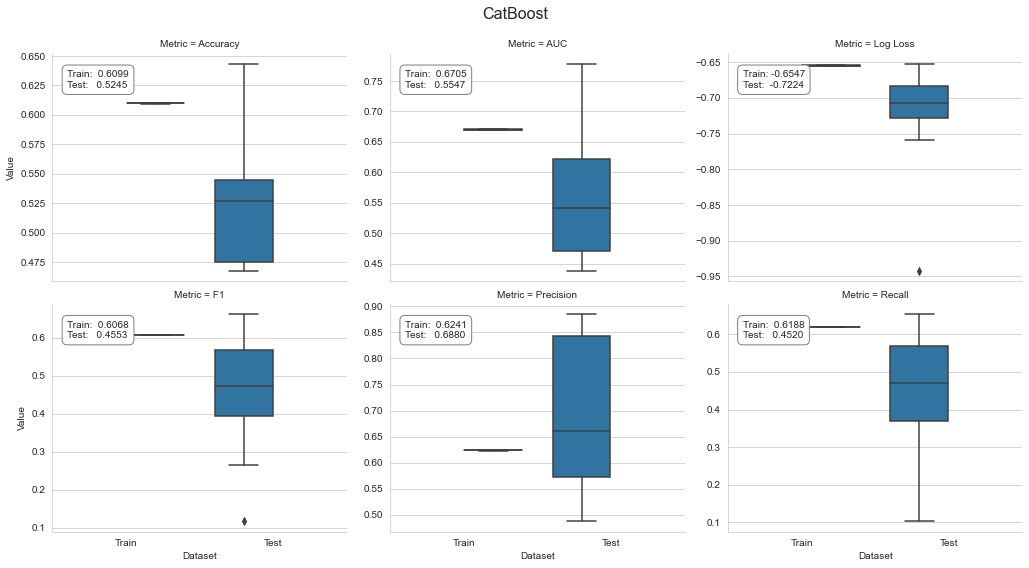

In [136]:
# Plotting cross-validation results
plot_result(cat_result, metrics, model='CatBoost')

In [8]:
# Preparing data for training
Y = pd.DataFrame((data.iloc[:,-6:]>0).astype(int))
X_train = X.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]
y_train = Y.loc[pd.IndexSlice[:, '2015-01-02':'2019-12-31'],:]

In [9]:
# Training model lag-wise
targets = [1,5,10,21,42,63]
y_pred = pd.DataFrame(index = Y.index)
for x in range(len(targets)):
    cat_clf.fit(X=X_train, y=y_train.iloc[:,x])
    y_p = cat_clf.predict(X)
    y_p = pd.DataFrame(y_p, index=Y.index, columns=[Y.columns[x]])
    y_pred = y_pred.join(y_p)

In [10]:
# Predictions
y_pred

target1day  target5day  target10day  target21day  \
ticker date                                                           
A      2015-01-02           0           1            1            1   
       2015-01-05           0           1            1            1   
       2015-01-06           1           1            1            1   
       2015-01-07           1           1            1            1   
       2015-01-08           0           1            1            1   
...                       ...         ...          ...          ...   
ZTS    2020-09-25           0           1            0            0   
       2020-09-28           1           1            1            0   
       2020-09-29           1           1            1            1   
       2020-09-30           1           0            0            0   
       2020-10-01           1           0            0            1   

                   target42day  target63day  
ticker date                                  
A      2015-01-02            1            1  
       2015-01-05            1            1  
       2015-01-06            1            1  
       2015-01-07            1            1  
       2015-01-08            1            1  
...                        ...          ...  
ZTS    2020-09-25            0            0  
       2020-09-28            0            0  
       2020-09-29            0            0  
       2020-09-30            0            0  
       2020-10-01            1            1  

[709062 rows x 6 columns]

In [11]:
#Getting OHLCV data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.set_index(["ticker", "date"], inplace=True)
ohlcv.sort_index(inplace=True)
ohlcv.dropna(inplace=True)

In [12]:
# Joining OHLCV data with predictions
cat_preds = ohlcv.join(y_pred).dropna()
cat_preds.reset_index(inplace=True)
cat_preds.date = pd.to_datetime(cat_preds.date)
cat_preds.set_index(['ticker','date'], inplace=True)

In [13]:
cat_preds.to_csv('./predictions/cat_preds.csv')